In [1]:
import numpy as np
import qutip as qutip
import time as time

from matplotlib import pyplot as plt

import sys
sys.path.append('../../utils')

from tomography import coherent_state_tomography as cst
from visualization import state_visualization as state_vis

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# In this notebook we sweep the width of the phase-space square we're using for coherent state tomography to see how it affects convergence and fidelity

# I'm assuming 4.4 noise photons and using a mesh size of 0.5

<IPython.core.display.Javascript object>


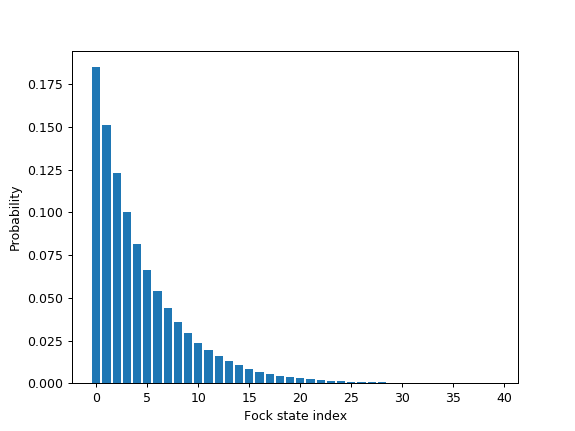

<IPython.core.display.Javascript object>


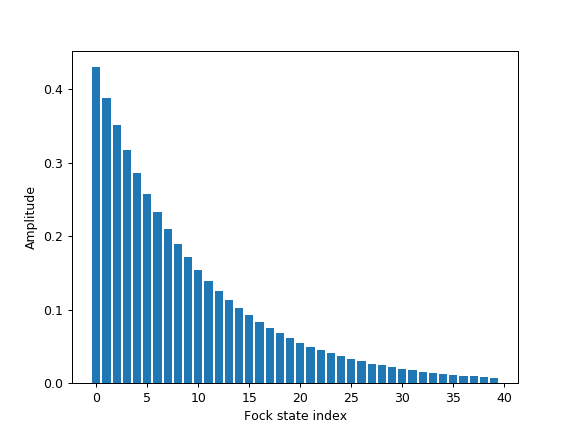

In [36]:
# First we see how many Fock states have nonnegligible weight in a thermal state of average photon number 4.4
dim = 40 # Generously large to ensure we resolve the entire thermal state
number_of_noise_photons = 4.4
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
state_vis.plot_fock_basis_probabilities(noise_state)
state_vis.plot_fock_basis_amplitudes(noise_state)

<IPython.core.display.Javascript object>


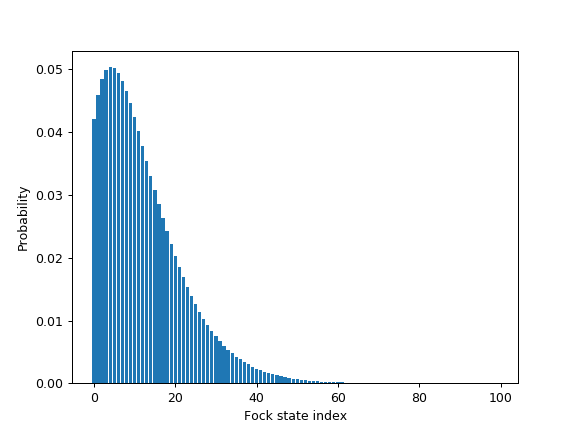

<IPython.core.display.Javascript object>


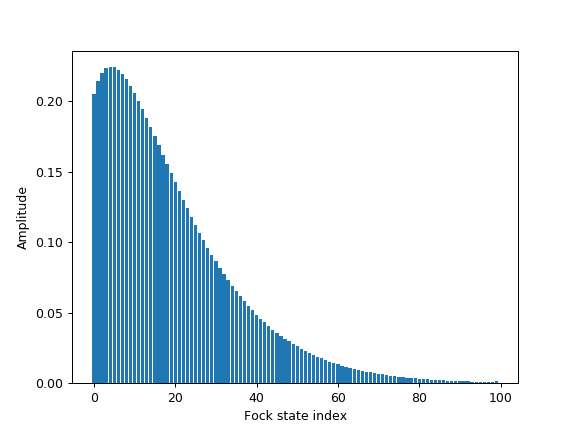

In [38]:
# We should also see what happens when we shift a thermal noise state of 4.4 photons on average
# to the corner of our mesh, as that will be the most extremal state of our noisy POVM

# Increase the dimension by like, a lot
dim = 100
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

corner_alpha = 2 + 2j
shifted_noise_state = qutip.displace(dim, corner_alpha) * noise_state \
                    * qutip.displace(dim, corner_alpha).dag()
state_vis.plot_fock_basis_probabilities(shifted_noise_state)
state_vis.plot_fock_basis_amplitudes(shifted_noise_state)

In [16]:
# Define range of widths
smallest_halfwidth = 4
largest_halfwidth = 7
steps = 8
max_xs = np.linspace(smallest_halfwidth, largest_halfwidth, steps)

mesh_size = 0.5
dim = 130

In [17]:
# Define the noise
number_of_noise_photons = 4.4
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

In [34]:
# Sweep the max_xs and extract the results for each case
reconstructed_states = []
noisy_data_Q_functions = []
fidelities_per_max_x = []
final_fidelities_per_max_x = []
xs_per_max_x = []
ps_per_max_x = []

for max_x in max_xs:
    # Construct the noisy POVM that we'll use for tomography
    noisy_povm, alphas, xs, ps = cst.generate_coherent_state_POVM(max_x, 
                                                                  mesh_size, 
                                                                  dim, 
                                                                  noise_base=noise_state)
    xs_per_max_x.append(xs)
    ps_per_max_x.append(ps)

    # Define the input state and use the noise state to generate its noisy Q function
    #
    # The Q function of a state is its ideal input for coherent state POVM as it is literally
    # defined to be Q(alpha; rho) = 1/pi * (<alpha|rho|alpha>) = Tr(rho * POVM_alpha)
    input_state = (qutip.basis(dim, 0) + qutip.basis(dim, 1)).unit()
    noise_Q_function = qutip.qfunc(noise_state, xs, ps, g=2)
    noisy_data_Q_function = \
        cst.evaluate_thermally_noisy_Q_function(input_state, 
                                                number_of_noise_photons, 
                                                xs, 
                                                ps)
    noisy_data_Q_functions.append(noisy_data_Q_function)
    
    # Perform MLE
    number_of_mle_iterations = 500
    s = time.time()
    reconstructed_state, fidelities = cst.perform_coherent_state_MLE(
                                        noisy_povm,
                                        noisy_data_Q_function, 
                                        number_of_mle_iterations,
                                        rho_ideal=input_state)
    e = time.time()
    print('Time for MLE reconstruction for max_x = ' + str(max_x) + ': ' + str(e - s) + ' s')
    
    reconstructed_states.append(reconstructed_state)
    fidelities_per_max_x.append(fidelities)
    final_fidelities_per_max_x.append(fidelities[-1])

Time for MLE reconstruction for max_x = 4.0: 103.79054117202759 s
Time for MLE reconstruction for max_x = 4.428571428571429: 151.74477291107178 s
Time for MLE reconstruction for max_x = 4.857142857142857: 175.46044731140137 s
Time for MLE reconstruction for max_x = 5.285714285714286: 194.91760730743408 s
Time for MLE reconstruction for max_x = 5.714285714285714: 196.28149795532227 s
Time for MLE reconstruction for max_x = 6.142857142857142: 208.1051061153412 s
Time for MLE reconstruction for max_x = 6.571428571428571: 229.80703592300415 s
Time for MLE reconstruction for max_x = 7.0: 205.68432307243347 s


<IPython.core.display.Javascript object>


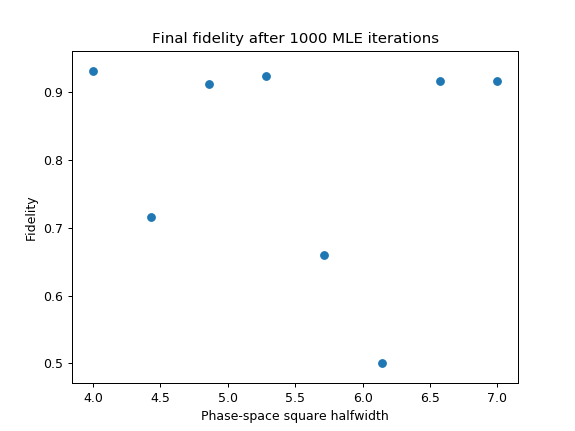

Text(0.5, 1.0, 'Final fidelity after 1000 MLE iterations')

In [35]:
# Plot the final fidelities
fig, ax = plt.subplots()
ax.scatter(max_xs, final_fidelities_per_max_x, marker='o')
ax.set_xlabel('Phase-space square halfwidth')
ax.set_ylabel('Fidelity')
ax.set_title('Final fidelity after 1000 MLE iterations')

In [ ]:
# It seems like we can see the consequences of including states in our mesh that require too many
# photons with respect to the dimension of our truncated Fock space

0.8581489464971578


<IPython.core.display.Javascript object>


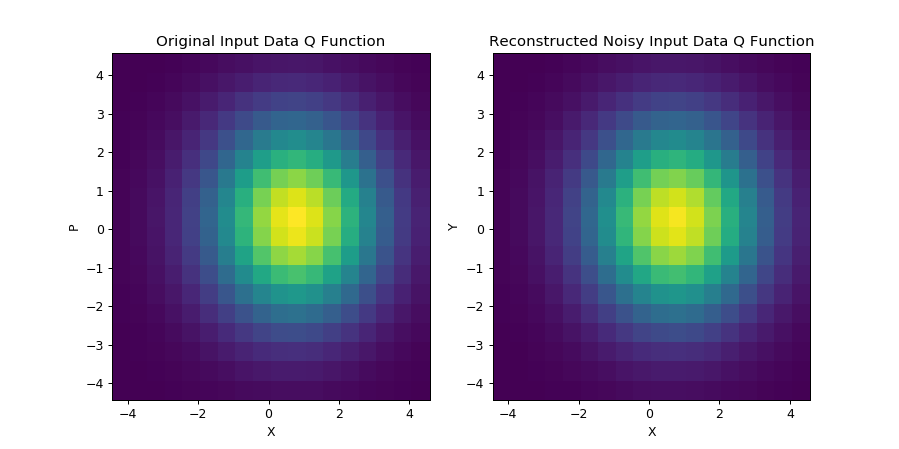

<IPython.core.display.Javascript object>


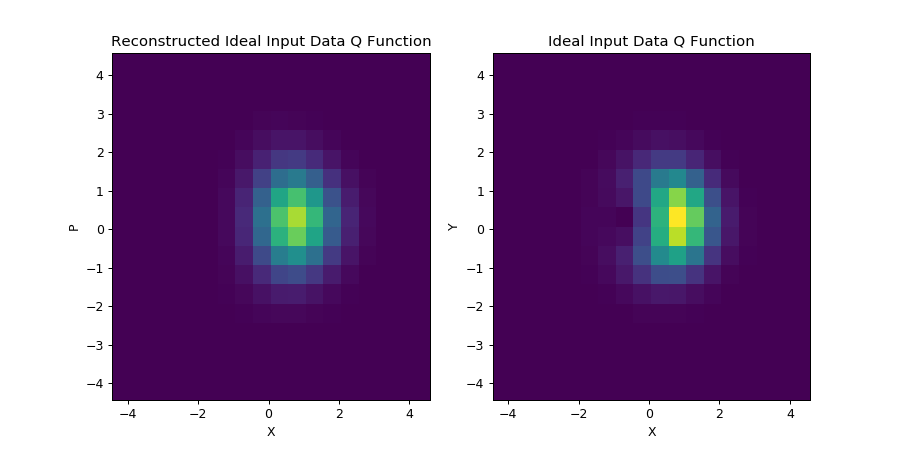

<IPython.core.display.Javascript object>


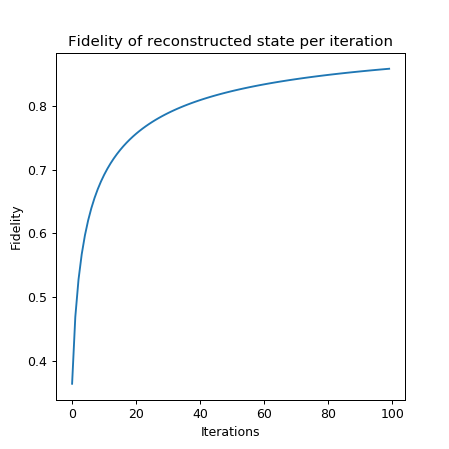

In [31]:
i = 1
rs = reconstructed_states[i]
ndQf = noisy_data_Q_functions[i]
fs = fidelities_per_max_x[i]
xs = xs_per_max_x[i]
ps = ps_per_max_x[i]

print(fs[-1])

cst.plot_coherent_state_tomography_Q_functions(ndQf,
                                               rs,
                                               xs,
                                               ps,
                                               noise_photon_number=number_of_noise_photons,
                                               ideal_state=input_state,
                                               fidelities=fs)

In [88]:
# I am uncertain about whether or not using a small square is actually a bad idea, so I'm going to try
# mle with a well-represented small square of halfwidth 2

max_x = 4
mesh_size = 0.5
dim = 40 # I'm actually skeptical that this is even high enough really
number_of_noise_photons = 2
noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
target_state = (qutip.basis(dim, 0) + qutip.basis(dim, 1)).unit()
target_state = target_state * target_state.dag()

# Make the noisy POVM
noisy_povm, alphas, xs, ps = cst.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim, 
                                                              noise_base=noise_state)
noiseless_povm, alphas, xs, ps = cst.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim)

# We'll make the data with high dimensional states to ensure it's 'close to real'
high_dim = 200
clean_target_state = (qutip.basis(high_dim, 0) + qutip.basis(high_dim, 1)).unit()
clean_target_state = clean_target_state * clean_target_state.dag()
clean_ideal_target_Q_function = qutip.qfunc(clean_target_state, xs, ps, g=2)
clean_noisy_target_Q_function = cst.evaluate_thermally_noisy_Q_function(clean_target_state, 
                                                                  number_of_noise_photons, 
                                                                  xs, 
                                                                  ps)

# Also make low dimensional data for testing
ideal_target_Q_function = qutip.qfunc(target_state, xs, ps, g=2)
noisy_target_Q_function = cst.evaluate_thermally_noisy_Q_function(target_state, 
                                                                  number_of_noise_photons, 
                                                                  xs, 
                                                                  ps)


# And now we'll try to reconstruct the input state
number_of_mle_iterations = 1000
s = time.time()
reconstructed_state, fidelities = cst.perform_coherent_state_MLE(
                                    noisy_povm,
                                    noisy_target_Q_function, 
                                    number_of_mle_iterations,
                                    rho_ideal=target_state)
e = time.time()
print('Time for MLE reconstruction for max_x = ' + str(max_x) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for max_x = 4: 127.03253769874573 s


Final state fidelity: 0.9746529892434217


<IPython.core.display.Javascript object>


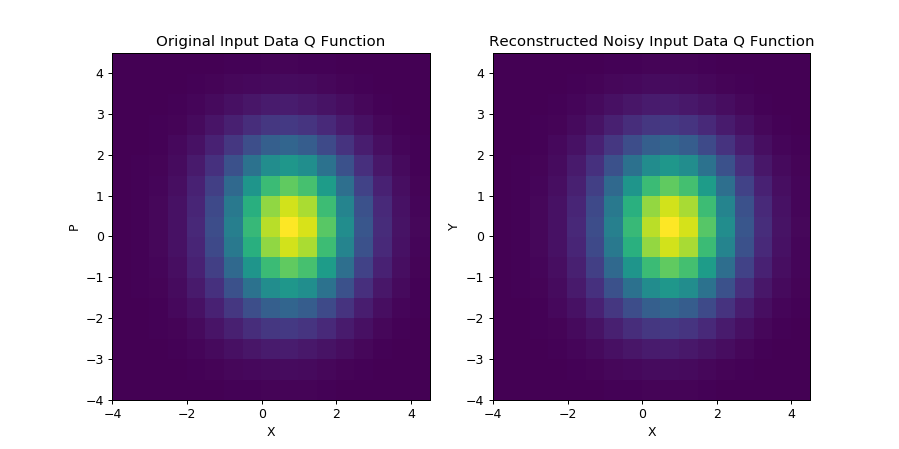

<IPython.core.display.Javascript object>


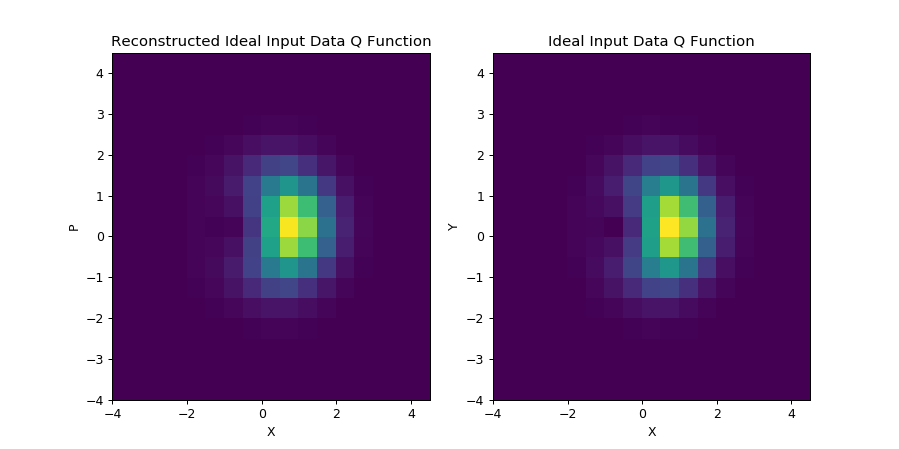

<IPython.core.display.Javascript object>


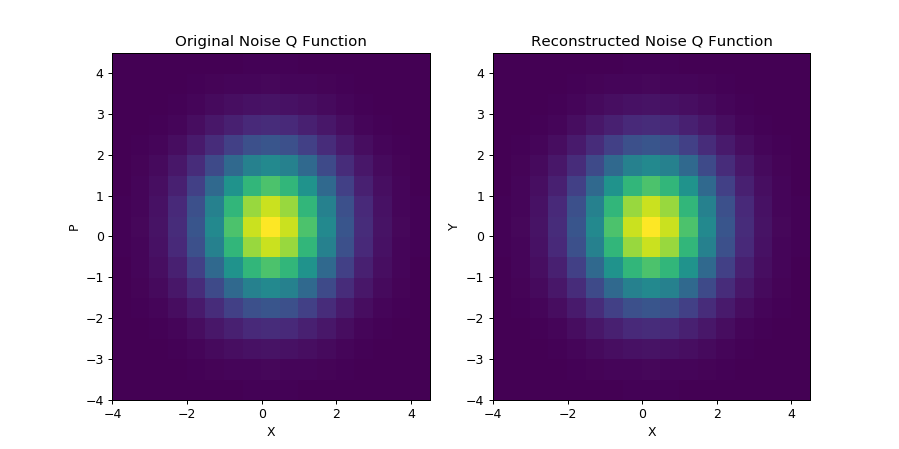

<IPython.core.display.Javascript object>


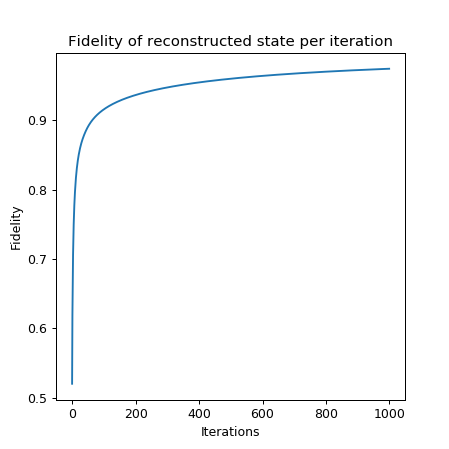

In [89]:
# Plot results
fidelity = qutip.fidelity(reconstructed_state, target_state)
print('Final state fidelity: ' + str(fidelity))
noise_qfunc = qutip.qfunc(noise_state, xs, ps, g=2)
cst.plot_coherent_state_tomography_Q_functions(noisy_target_Q_function,
                                               reconstructed_state,
                                               xs,
                                               ps,
                                               noise_data=noise_qfunc,
                                               noise_photon_number=number_of_noise_photons,
                                               ideal_state=target_state,
                                               fidelities=fidelities)

<IPython.core.display.Javascript object>


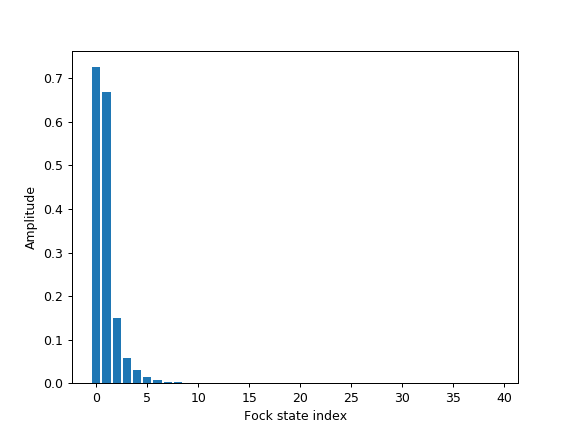

In [90]:
state_vis.plot_fock_basis_amplitudes(reconstructed_state)

In [64]:
print(len(noisy_target_Q_function[0]))

17
